In [45]:
from qpms import Particle, CTMatrix, lorentz_drude, EpsMuGenerator, TMatrixGenerator, BaseSpec, FinitePointGroup, ScatteringSystem, TMatrixInterpolator, EpsMu, dbgmsg_enable, dbgmsg_disable, dbgmsg_active, BesselType,eV, hbar, c
from qpms.symmetries import point_group_info
import numpy as np
eh = eV/hbar
np.random.seed(666)
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle, Circle
from mpl_toolkits.axes_grid1 import AxesGrid

def cleanarray(a, atol=1e-10, copy=True):
    a = np.array(a, copy=copy)
    sieve = abs(a.real) < atol
    a[sieve] = 1j * a[sieve].imag
    sieve = abs(a.imag) < atol
    a[sieve] = a[sieve].real
    return a

In [46]:
dbgmsg_enable(2)
part_radius = 80e-9

In [51]:
lMax=2
grpname='D4h'

sym = FinitePointGroup(point_group_info[grpname])
bspec1 = BaseSpec(lMax=lMax)
medium=EpsMuGenerator(EpsMu(1.52**2))
#t1 = CTMatrix(bspec1, np.diag(np.random.random(len(bspec1))))
t1 = TMatrixGenerator.sphere(medium, EpsMuGenerator(lorentz_drude['Au']), r=part_radius)
p1 = Particle((0,0,0),t1,bspec=bspec1)
ss, ssw = ScatteringSystem.create([p1], EpsMuGenerator(EpsMu(1.52**2)), 1.4*eh, sym)
lambd = 2*np.pi/ssw.wavenumber.real
ss.particles_tmi
ss.irrep_names

["A1'", "A1''", "A2'", "A2''", "B1'", "B1''", "B2'", "B2''", "E'", "E''"]

In [52]:
p = 310e-9
line = np.linspace(-p/2,p/2,50)
pxw = line[1]-line[0]
xygrid = np.stack(np.meshgrid(line,line,(0,), indexing='ij')).T
xygrid.shape=xygrid.shape[1:]
xygrid_s = xygrid - np.array([pxw/2, pxw/2, 0]) # correction of pcolormesh coordinates
xzgrid = np.stack(np.meshgrid(line,(0,),line, indexing='ij')).T
xzgrid.shape = (len(line), len(line), 3)
xzgrid_s = xzgrid - np.array([pxw/2, 0, pxw/2])

pr = part_radius
ph = 50e-9
def add_particle_xy(ax):
    particle_xy = Circle((0,0), pr/lambd, fill=False, lw=2, color='grey')
    ax.add_patch(particle_xy)
def add_particle_xz(ax):
    particle_xz = Rectangle((-pr/lambd,-ph/lambd/2), 2*pr/lambd, ph/lambd, fill=False, lw=2, color='grey')
    ax.add_patch(particle_xz)

2 1 -1
Real maxes: [0.16281065 0.02993536 0.        ] [ 0.16281065 -0.          0.02993536]
Imag maxes: [ 0.02993536 -0.05831867  0.        ] [ 0.         -0.02838331  0.        ]
2 1 0
Real maxes: [0.         0.         0.23022223] [0.042335   0.         0.23024903]
Imag maxes: [0. 0. 0.] [0. 0. 0.]
2 1 1
Real maxes: [-0.05831867  0.02993536  0.        ] [-0.05831867 -0.          0.02993536]
Imag maxes: [ 0.02993536 -0.05831867  0.        ] [ 0.         -0.02838331  0.        ]
2 2 -2
Real maxes: [ 0.08594358  0.08594358 -0.        ] [0.08594857 0.         0.01018863]
Imag maxes: [0.07397498 0.07397498 0.        ] [0.       0.073965 0.      ]
2 2 -1
Real maxes: [-0.       -0.        0.073965] [0.07397498 0.         0.07397498]
Imag maxes: [0.       0.       0.073965] [0.       0.073965 0.      ]
2 2 0
Real maxes: [0.07018079 0.07018079 0.        ] [0.07016857 0.         0.14034936]
Imag maxes: [0. 0. 0.] [0. 0. 0.]
2 2 1
Real maxes: [-0.       -0.        0.073965] [0.07397498 0.      

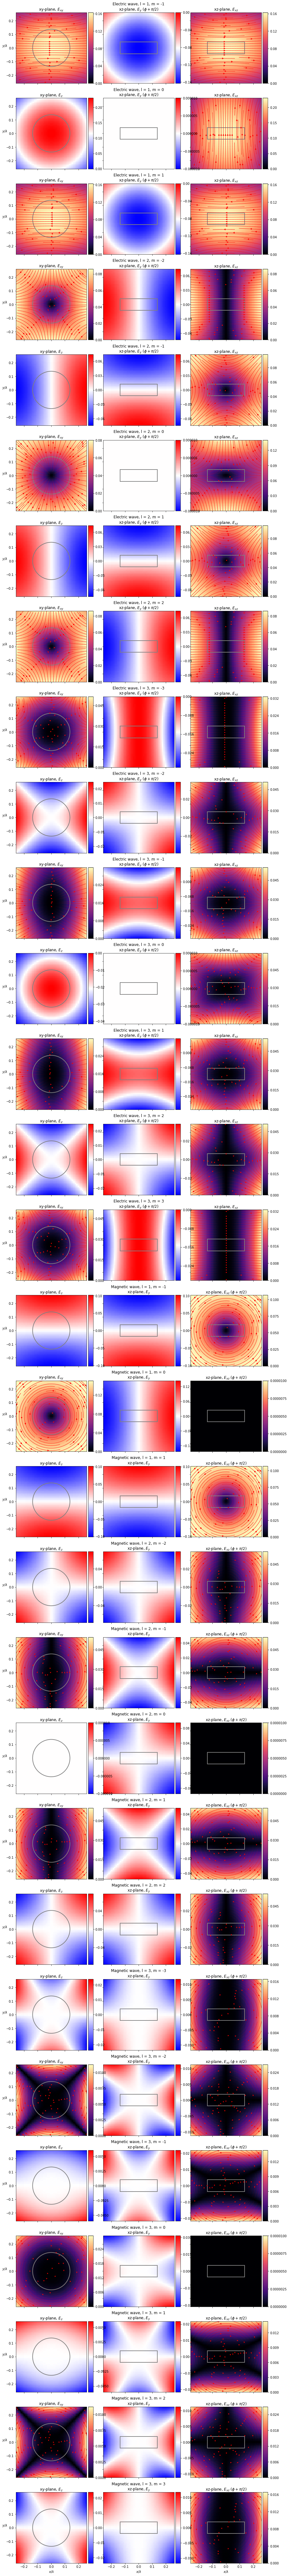

In [49]:
t,l,m = bspec1.tlm()
btyp = BesselType.REGULAR
ilist = list(range(ss.fecv_size))
#f,axrows = plt.subplots(len(ilist), 3, figsize=(16, 5*len(ilist)))
f = plt.figure(figsize=(16, 5*len(ilist)))
grid = AxesGrid(f, 111,  # similar to subplot(111)
                nrows_ncols=(len(ilist), 3),
                axes_pad=(0.45, 0.65),
                label_mode="L",
                share_all=False,
                cbar_location="right",
                cbar_mode="each",
                cbar_size="7%",
                cbar_pad="2%",
                )

lwfac = 1
extent=(-p/2/lambd,p/2/lambd,-p/2/lambd,p/2/lambd) # for imshow

for i in ilist:
    #ax = axrows[i]
    ax = grid[i*3:(i+1)*3]
    cbax = grid.cbar_axes[i*3:(i+1)*3]
    fvc = np.zeros((ss.fecv_size,), dtype=complex)
    fvc[i] = 1

    print(t[i],l[i],m[i])
    el = t[i] == 2

    xyE = cleanarray(ssw.scattered_E(fvc, xygrid, btyp=btyp), copy=False)
    xzE = cleanarray(ssw.scattered_E(fvc, xzgrid, btyp=btyp), copy=False)

    print("Real maxes:", np.amax(xyE.real, axis=(0,1)),np.amax(xzE.real, axis=(0,1)))
    print("Imag maxes:", np.amax(xyE.imag, axis=(0,1)),np.amax(xzE.imag, axis=(0,1)))

    if btyp != BesselType.REGULAR:
        xyE[np.linalg.norm(xygrid,axis=-1)<part_radius] = np.nan
        xzE[np.linalg.norm(xzgrid,axis=-1)<part_radius] = np.nan
    
    #f, ax = plt.subplots(1,3, figsize=(33,9))
    #f.suptitle("%s wave, l = %d, m = %d" % ("Electric" if el else "Magnetic", l[i], m[i]))

    z_even = ((t[i] + l[i] + m[i]) % 2 == 0)
    if z_even:
        ax[0].set_title("xy-plane, $E_{xy}$")
        ax[0].set_xlabel("$x/\lambda$"); ax[0].set_ylabel("$y/\lambda$", rotation="horizontal")

        speed = np.linalg.norm(xyE.real[...,:2], axis=-1)
        lw = lwfac*speed/np.amax(speed)
        #c = ax[0].pcolormesh(xygrid_s[...,0]/lambd, xygrid[...,1]/lambd, speed, cmap=cm.magma, vmin=0, vmax=max(1e-5,np.amax(speed)))
        c = ax[0].imshow(speed, origin='lower', extent=extent, cmap=cm.magma, vmin=0, vmax=max(1e-5,np.amax(speed)), interpolation='none')
        add_particle_xy(ax[0])
        ax[0].streamplot(xygrid[...,0]/lambd, xygrid[...,1]/lambd, xyE[...,0].real, xyE[...,1].real,
                      linewidth=lw,color='r'                     )
        #ax[0].quiver(xygrid[...,0]/lambd, xygrid[...,1]/lambd, xyE[...,0].real, xyE[...,1].real,color="w")
        cb = cbax[0].colorbar(c)
        #cb.set_label('$|E|$', rotation="horizontal")
    else:
        ax[0].set_title("xy-plane, $E_{z}$")
        ax[0].set_xlabel("$x/\lambda$"); ax[0].set_ylabel("$y/\lambda$", rotation="horizontal")
        #c = ax[0].pcolormesh(xygrid_s[...,0]/lambd, xygrid_s[...,1]/lambd, xyE[...,2].real, cmap=cm.bwr)
        vmin, vmax = min(-1e-5, np.amin(xyE[...,2].real)), max(1e-5, np.amax(xyE[...,2].real))
        c = ax[0].imshow(xyE[...,2].real, origin='lower', cmap=cm.bwr, extent=extent, vmin=vmin, vmax=vmax, interpolation='none')
        add_particle_xy(ax[0])
        cb = cbax[0].colorbar(c)
        #cb.set_label('$E_z$', rotation="horizontal")


    xzEy = xzE.imag if el else xzE.real
    ax[1].set_title(("%s wave, l = %d, m = %d\n" % ("Electric" if el else "Magnetic", l[i], m[i]))+("xz-plane, $E_{y}$" + (" ($\phi + \pi/2$)" if el else "")))
    ax[1].set_xlabel("$x/\lambda$"); ax[1].set_ylabel("$z/\lambda$", rotation="horizontal")

    #c = ax[1].pcolormesh(xzgrid_s[...,0]/lambd, xzgrid_s[...,2]/lambd, xzEy[...,1], cmap=cm.bwr)
    vmin, vmax = min(-1e-5, np.amin(xzEy[...,1])), max(1e-5, np.amax(xzEy[...,1]))
    c = ax[1].imshow(xzEy[...,1], cmap=cm.bwr, origin='lower', extent=extent, vmin=vmin, vmax=vmax, interpolation='none')
    add_particle_xz(ax[1])
    cb = cbax[1].colorbar(c)
    #cb.set_label('$E_y$', rotation="horizontal")

    ax[2].set_title("xz-plane, $E_{xz}$" + ("" if el else " ($\phi + \pi/2$)"))
    ax[2].set_xlabel("$x/\lambda$"); ax[2].set_ylabel("$z/\lambda$", rotation="horizontal")

    xzExz = xzE.real if el else xzE.imag
    speed = np.linalg.norm(xzExz[...,0::2], axis=-1)

    #c = ax[2].pcolormesh(xzgrid_s[...,0]/lambd, xzgrid_s[...,2]/lambd, speed, vmin=0, vmax=max(1e-5,np.amax(speed)), cmap=cm.magma)
    c = ax[2].imshow(speed, vmin=0, vmax=max(1e-5,np.amax(speed)), cmap=cm.magma, origin='lower', extent=extent , interpolation='none')
    add_particle_xz(ax[2])
    if(np.amax(speed)>0):
        lw = lwfac*speed/np.amax(speed)
        ax[2].streamplot(line/lambd, line/lambd, xzExz[...,0], xzExz[...,2],
                  linewidth=lw,color='r'
                 )
        #ax[2].quiver(xzgrid[...,0]/lambd, xzgrid[...,2]/lambd, xzExz[...,0], xzExz[...,2], color='w')
    cb = cbax[2].colorbar(c)
    #cb.set_label('$|E_{xz}|$', rotation="horizontal")
    for axi in range(3):
            ax[axi].set_xlim([(-p+pxw)/lambd/2, (p-pxw)/lambd/2])
            ax[axi].set_ylim([(-p+pxw)/lambd/2, (p-pxw)/lambd/2])

plt.savefig("wswfcuts_%s_lMax%d_%.2glambda.pdf" %(btyp.name, lMax, p/lambd) )


========================= A1' =====================
(1+0j)(E, 2, +0) 
Real maxes: [0.07018079 0.07018079 0.        ] [0.07016857 0.         0.14034936]
Imag maxes: [0. 0. 0.] [0. 0. 0.]

========================= A1'' =====================
(1+0j)(M, 2, +0) 
Real maxes: [0. 0. 0.] [0.         0.09466394 0.        ]
Imag maxes: [0. 0. 0.] [0. 0. 0.]

========================= A2' =====================
(1+0j)(M, 1, +0) 
Real maxes: [0.14379621 0.14379621 0.        ] [0.         0.14379621 0.        ]
Imag maxes: [0. 0. 0.] [0. 0. 0.]

========================= A2'' =====================
(1+0j)(E, 1, +0) 
Real maxes: [0.         0.         0.23022223] [0.042335   0.         0.23024903]
Imag maxes: [0. 0. 0.] [0. 0. 0.]

========================= B1' =====================
(0.7071067811865476+0j)(E, 2, -2) (0.7071067811865475+0j)(E, 2, +2) 
Real maxes: [ 0.12154258  0.12154258 -0.        ] [0.12154964 0.         0.0144089 ]
Imag maxes: [0. 0. 0.] [0. 0. 0.]

========================= B1'' =

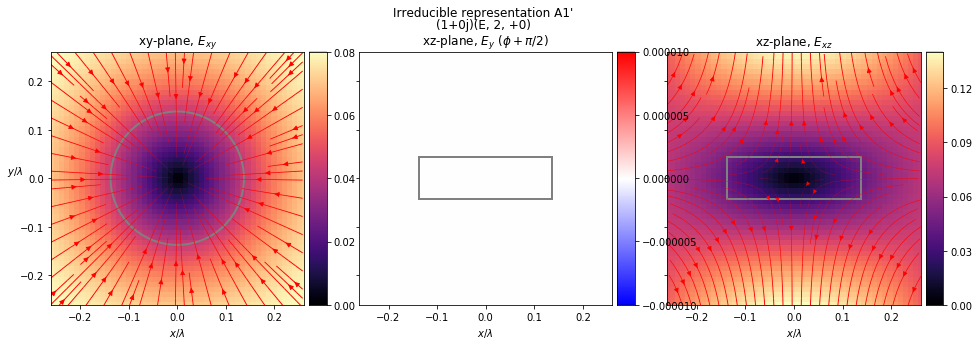

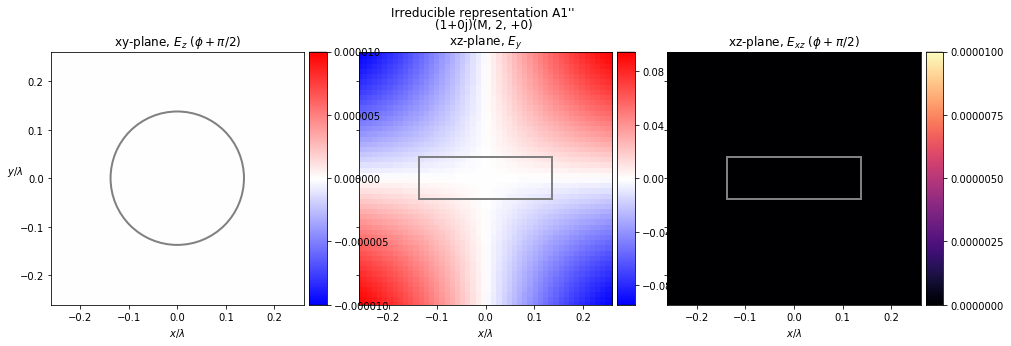

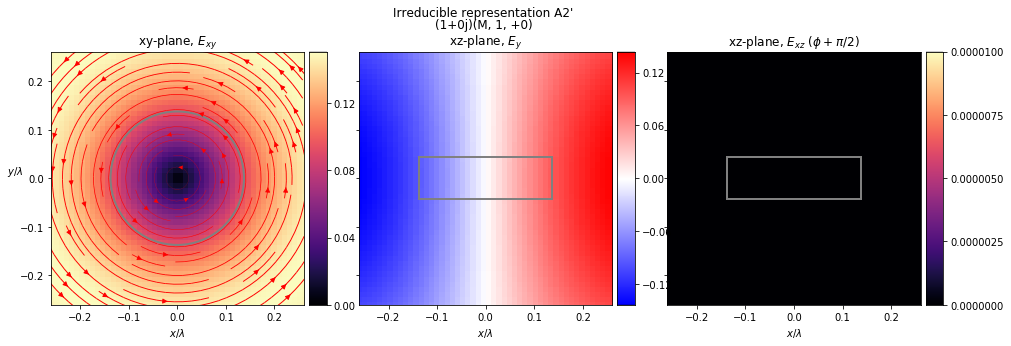

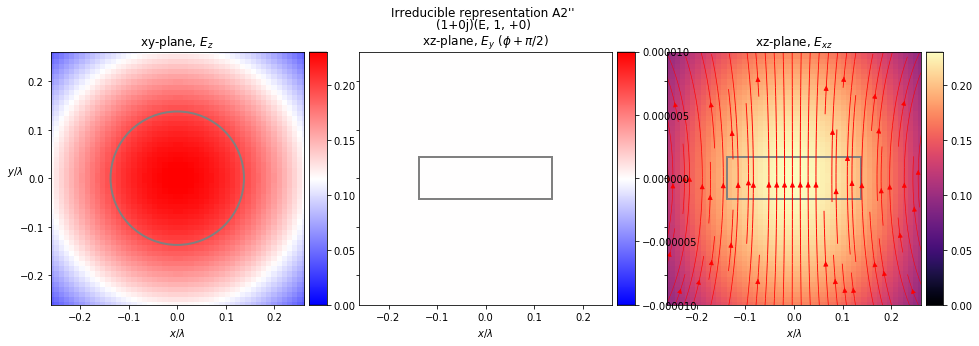

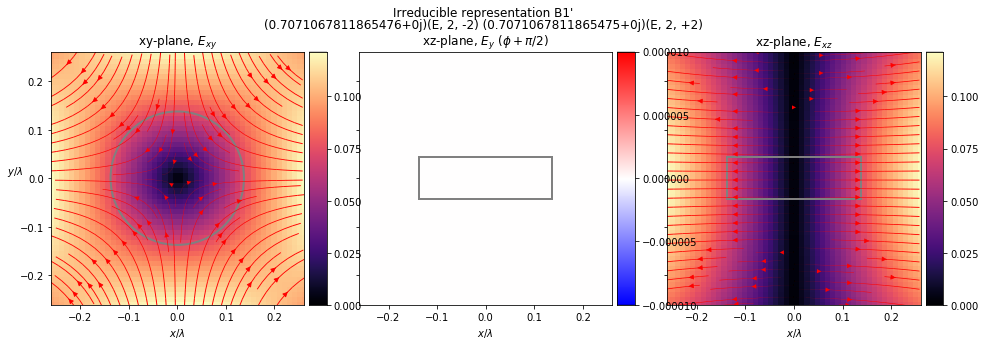

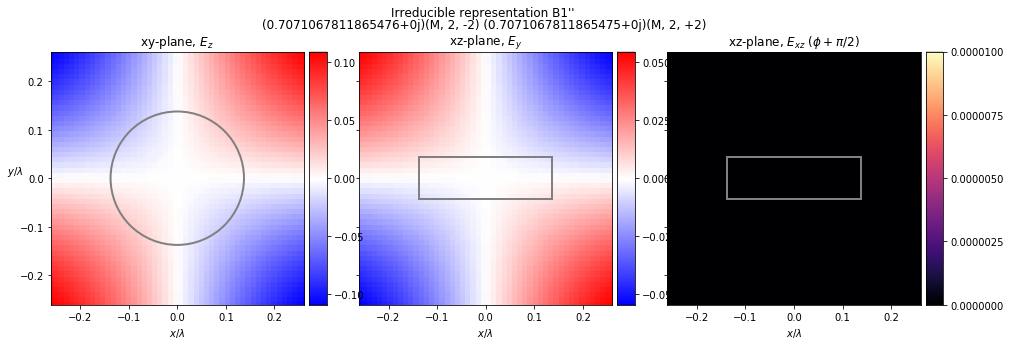

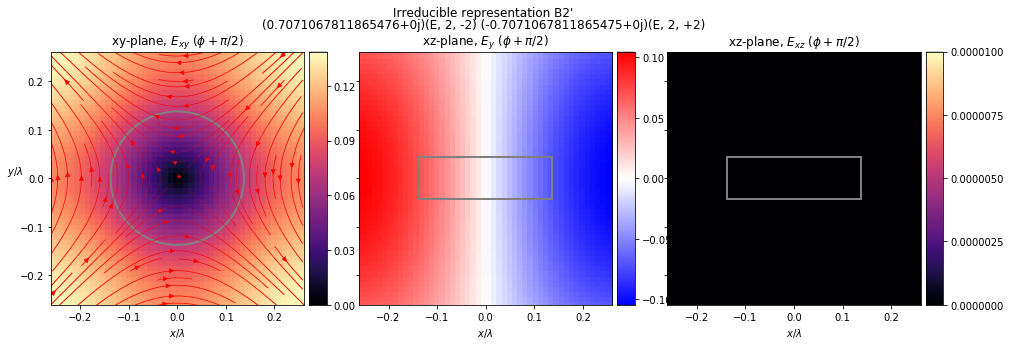

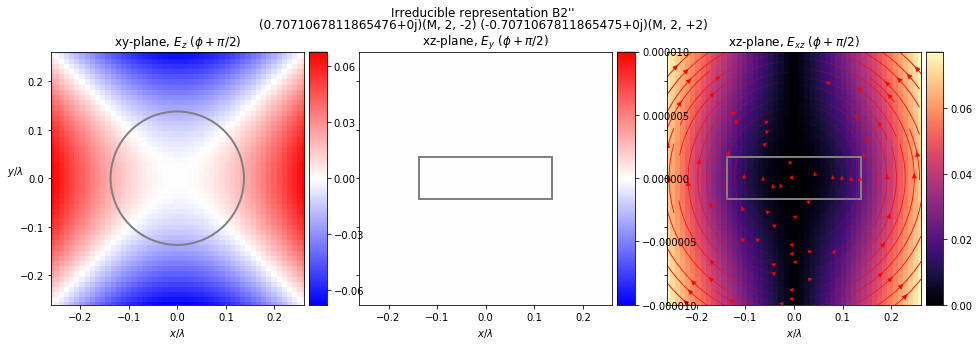

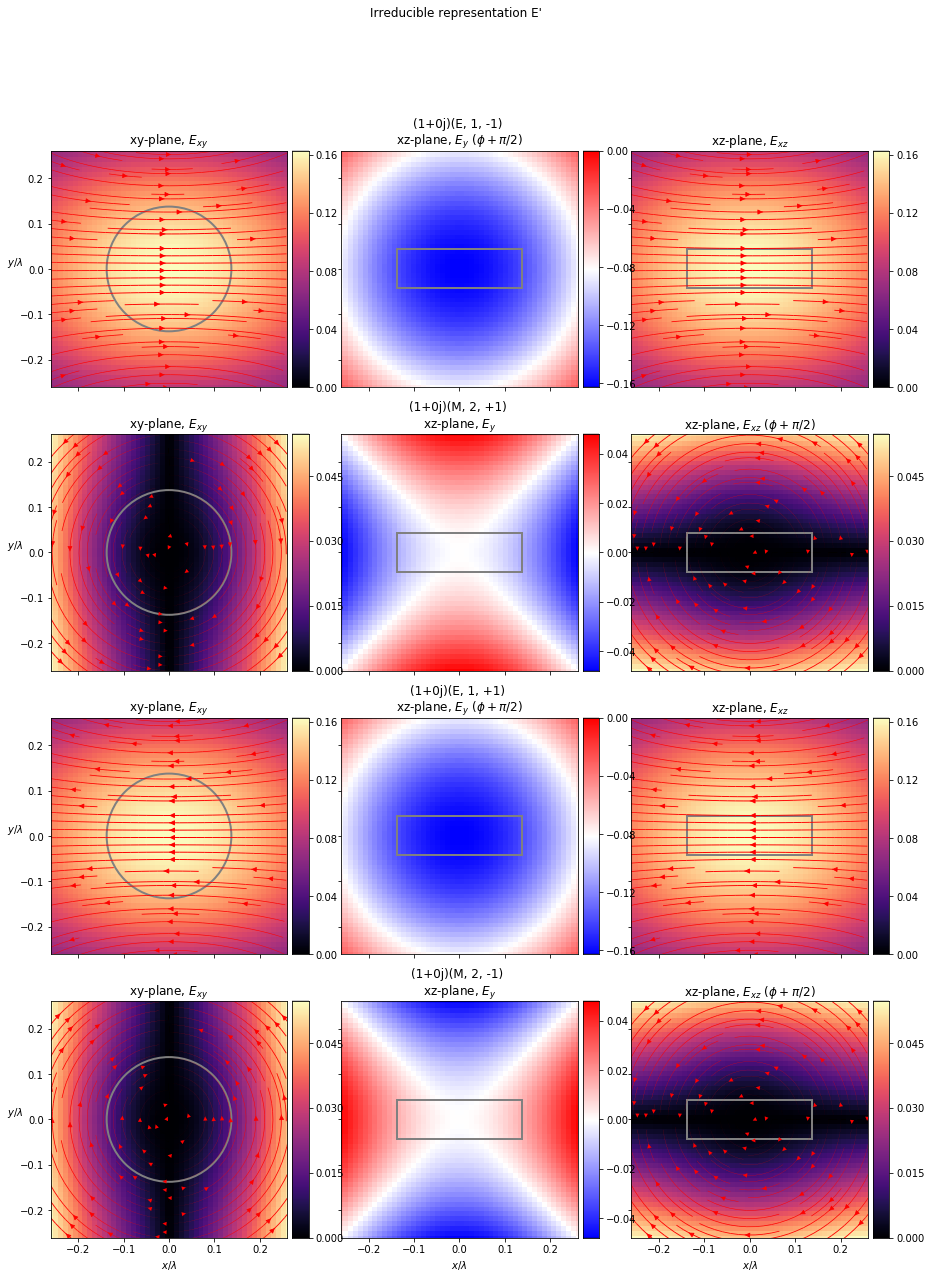

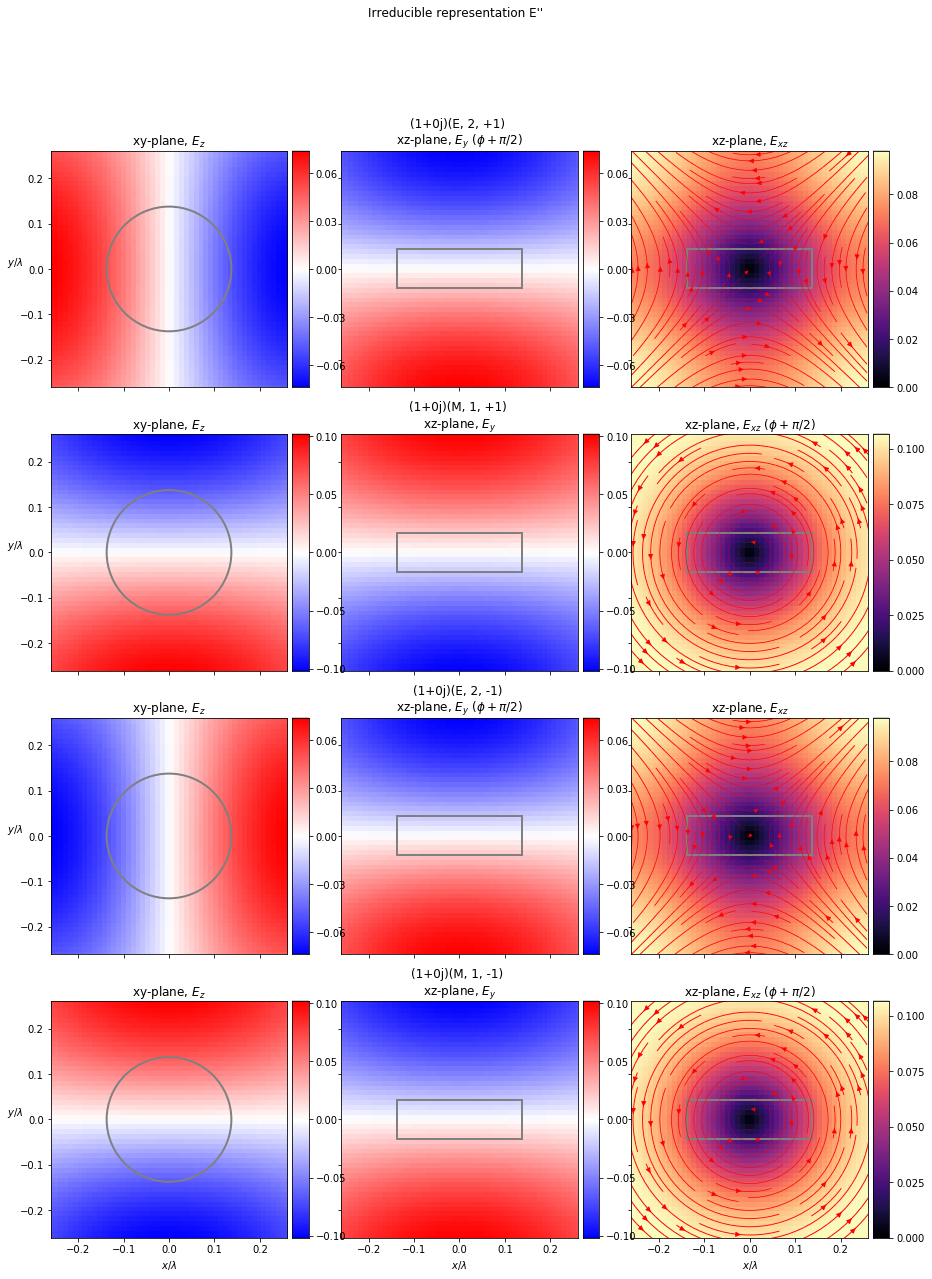

In [53]:
t,l,m = bspec1.tlm()
btyp = BesselType.REGULAR
extent=(-p/2/lambd,p/2/lambd,-p/2/lambd,p/2/lambd) # for imshow

with  PdfPages("%s_wswfcuts_%s_lMax%d_%.2glambda.pdf" %(grpname, btyp.name, lMax, p/lambd)) as pdf:
  for iri in range(ss.nirreps): 
    ilist = list(range(ss.saecv_sizes[iri]))
    f = plt.figure(figsize=(16, 5*len(ilist)))
    grid = AxesGrid(f, 111,  # similar to subplot(111)
                nrows_ncols=(len(ilist), 3),
                axes_pad=(0.45, 0.65),
                label_mode="L",
                share_all=False,
                cbar_location="right",
                cbar_mode="each",
                cbar_size="7%",
                cbar_pad="2%",
                )
    #f,axrows = plt.subplots(len(ilist), 3, figsize=(11, 2+ 3*len(ilist)), squeeze=False)
    f.suptitle("Irreducible representation %s" % ss.irrep_names[iri])
    print("\n=========================", ss.irrep_names[iri], "=====================")

    for i in ilist:
        ax = grid[i*3:(i+1)*3]
        cbax = grid.cbar_axes[i*3:(i+1)*3]
        pvc = np.zeros((ss.saecv_sizes[iri],), dtype=complex)
        pvc[i] = 1
        fvc = ss.unpack_vector(pvc,iri)
        fvc_nonzero_i = [j for j in range(ss.fecv_size) if abs(fvc[j]) > 1e-5]
        fvc = cleanarray(fvc / fvc[fvc_nonzero_i[0]] * abs(fvc[fvc_nonzero_i[0]]), copy=False) # rotate phase
        
        descript = "".join((str(fvc[j]) + "(%s, %d, %+d) " % (("E" if t[j] == 2 else "M"), l[j], m[j]) for j in fvc_nonzero_i))
        print(descript)

        xyE = cleanarray(ssw.scattered_E(fvc, xygrid, btyp=btyp), copy=False)
        xzE = cleanarray(ssw.scattered_E(fvc, xzgrid, btyp=btyp), copy=False)

        print("Real maxes:", np.amax(xyE.real, axis=(0,1)),np.amax(xzE.real, axis=(0,1)))
        print("Imag maxes:", np.amax(xyE.imag, axis=(0,1)),np.amax(xzE.imag, axis=(0,1)))

        if btyp != BesselType.REGULAR:
            xyE[np.linalg.norm(xygrid,axis=-1)<part_radius] = 0 # np.nan
            xzE[np.linalg.norm(xzgrid,axis=-1)<part_radius] = 0 # np.nan

        #f, ax = plt.subplots(1,3, figsize=(33,9))
        #f.suptitle("%s wave, l = %d, m = %d" % ("Electric" if el else "Magnetic", l[i], m[i]))

        z_even = (np.nanmax(abs(xyE[...,:2])) != 0)
        xyE_is_real = (np.nanmax(xyE.real) != 0)
        xyEplot = xyE.real if xyE_is_real else xyE.imag
        if z_even:
            ax[0].set_title("xy-plane, $E_{xy}$" + ("" if xyE_is_real else " ($\phi + \pi/2$)"))
            ax[0].set_xlabel("$x/\lambda$"); ax[0].set_ylabel("$y/\lambda$", rotation="horizontal")

            speed = np.linalg.norm(xyEplot[...,:2], axis=-1)
            lw = lwfac*speed/np.amax(speed)
            #c = ax[0].pcolormesh(xygrid_s[...,0]/lambd, xygrid_s[...,1]/lambd, speed, cmap=cm.magma, vmin=0, vmax=max(1e-5,np.amax(speed)))
            c = ax[0].imshow(speed, origin='lower', extent=extent,  cmap=cm.magma, vmin=0, vmax=max(1e-5,np.amax(speed)), interpolation='none')
            add_particle_xy(ax[0])
            ax[0].streamplot(xygrid[...,0]/lambd, xygrid[...,1]/lambd, xyEplot[...,0], xyEplot[...,1],
                          linewidth=lw,color='r'                     )
            #ax[0].quiver(xygrid[...,0]/lambd, xygrid[...,1]/lambd, xyEplot[...,0], xyEplot[...,1],color="w")
            cb = cbax[0].colorbar(c)
            #cb.set_label('$|E|$', rotation="horizontal")
        else:
            ax[0].set_title("xy-plane, $E_{z}$" + ("" if xyE_is_real else " ($\phi + \pi/2$)"))
            ax[0].set_xlabel("$x/\lambda$"); ax[0].set_ylabel("$y/\lambda$", rotation="horizontal")
            #c = ax[0].pcolormesh(xygrid_s[...,0]/lambd, xygrid_s[...,1]/lambd, xyEplot[...,2], cmap=cm.bwr)
            vmin, vmax = min(-1e-5, np.amin(xyEplot[...,2])), max(1e-5, np.amax(xyEplot[...,2]))
            c = ax[0].imshow(xyEplot[...,2], cmap=cm.bwr, origin='lower', extent=extent, vmin=vmin, vmax=vmax, interpolation='none')
            add_particle_xy(ax[0])
            cb = cbax[0].colorbar(c)
            #cb.set_label('$E_z$', rotation="horizontal")


        y_is_real = (np.nanmax(xzE[...,1].real) != 0)
        xzEy = xzE.real if y_is_real else xzE.imag
        #ax[1].set_title(("%s wave, l = %d, m = %d\n" % ("Electric" if el else "Magnetic", l[i], m[i]))+("xz-plane, $E_{y}$" + (" ($\phi + \pi/2$)" if el else "")))
        ax[1].set_title(descript + "\nxz-plane, $E_y$" + ("" if y_is_real else " ($\phi + \pi/2$)"))
        ax[1].set_xlabel("$x/\lambda$"); ax[1].set_ylabel("$z/\lambda$", rotation="horizontal")

        #c = ax[1].pcolormesh(xzgrid_s[...,0]/lambd, xzgrid_s[...,2]/lambd, xzEy[...,1], cmap=cm.bwr)
        vmin, vmax = min(-1e-5, np.amin(xzEy[...,1])), max(1e-5, np.amax(xzEy[...,1]))
        c = ax[1].imshow(xzEy[...,1], origin='lower', cmap=cm.bwr, extent=extent, vmin=vmin, vmax=vmax, interpolation='none')
        add_particle_xz(ax[1])
        cb = cbax[1].colorbar(c)
        #cb.set_label('$E_y$', rotation="horizontal")


        xz_is_real = (np.nanmax(xzE[...,0::2].real) != 0)
        ax[2].set_title("xz-plane, $E_{xz}$" + ("" if xz_is_real else " ($\phi + \pi/2$)"))
        ax[2].set_xlabel("$x/\lambda$"); ax[2].set_ylabel("$z/\lambda$", rotation="horizontal")
        xzExz = xzE.real if xz_is_real else xzE.imag
        speed = np.linalg.norm(xzExz[...,0::2], axis=-1)

        #c = ax[2].pcolormesh(xzgrid_s[...,0]/lambd, xzgrid_s[...,2]/lambd, speed, vmin=0, vmax=max(1e-5,np.amax(speed)), cmap=cm.magma)
        c = ax[2].imshow(speed, origin='lower', extent=extent, vmin=0, vmax=max(1e-5,np.amax(speed)), cmap=cm.magma, interpolation='none')
        add_particle_xz(ax[2])
        if(np.amax(speed)>0):
            lw = lwfac*speed/np.amax(speed)
            ax[2].streamplot(line/lambd, line/lambd, xzExz[...,0], xzExz[...,2],
                      linewidth=lw,color='r'
                     )
            #ax[2].quiver(xzgrid[...,0]/lambd, xzgrid[...,2]/lambd, xzExz[...,0], xzExz[...,2], color='w')
        cb = cbax[2].colorbar(c)
        #cb.set_label('$|E_{xz}|$', rotation="horizontal")
        
        for axi in range(3):
            ax[axi].set_xlim([(-p+pxw)/lambd/2, (p-pxw)/lambd/2])
            ax[axi].set_ylim([(-p+pxw)/lambd/2, (p-pxw)/lambd/2])
    pdf.savefig()
